# 1. 패키지, 모듈, 클래스, 함수 불러오기

In [ ]:
# klib , missingno 패키지 (EDA 패키지)
!pip install klib
!pip install missingno

# pycaret 패키지
!pip install -upgrade matplotlib pandas seaborn tqdm requests
!pip install pycaret
!pip install shap awscli azure-storage-blob google-cloud-storage psutil

# 베이지안 최적화 optuna 패키지
!pip install optuna

# catboost 모델 패키지
!pip install catboost

# tensorflow 패키지
!pip install tensorflow

!pip install shap

# 자연어처리
#!pip install gensim


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [ ]:
# Data Wrangling
import pandas as pd
import numpy as np
import pandas_profiling as pp
import gc

# Visualization, EDA
import missingno as msno
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Korean font
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#rc('font', family=font_name)

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna

# Modeling
from lightgbm import LGBMClassifier
from pycaret.classification import *
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import *
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import re
import os
import time
import datetime
import random
import tensorflow as tf
import pickle
import joblib
import platform
import warnings; warnings.filterwarnings("ignore")
from itertools import combinations
from tqdm import tqdm, tqdm_notebook
from IPython.display import Image
from scipy.stats.mstats import gmean
from tensorflow import keras

#자연어처리
#from gensim.models.fasttext import FastText

In [ ]:
# 코랩에서만 결로 설정
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. 데이터 불러오기

In [ ]:
# 주피터 파일일때(주석처리)
# path = ""

# 코랩 파일일때(주석처리)
path = "/content/drive/MyDrive/"

panel = pd.read_csv(path + 'panel.csv')
survey = pd.read_csv(path + 'survey.csv')
response_train = pd.read_csv(path + 'response_train.csv')
response_test = pd.read_csv(path + 'response_test.csv')

# 성별, 지역 값이 Nan 값인 패널 1명 test에도 존재 하지 않아 그냥 drop
panel.drop(8315, axis=0, inplace=True)
# REGION 컬럼 무의미해서 drop
panel.drop(['REGION'], axis=1, inplace=True)

# CATEGORIES 컬럼 Nan 값도 많고 무의미해서 drop
survey.drop(['CATEGORIES'], axis=1, inplace=True)

# 3. Feature Create

##### (패널 질문 응답수), (응답수 별 범위), (응답수 범위별 응답 확률)

In [ ]:
# 패널 질문 COUNT(질문의 성의 판단)
panel_Questions = panel.iloc[:,4:]

panel = panel.iloc[:,:4]
panel_Questions_count = []
for i in range(panel_Questions.shape[0]):
            panel_Questions_count.append(pd.notna(panel_Questions.iloc[i,:].values).sum())

# 패널 질문 응답수
panel['Questions_count'] = panel_Questions_count

# 패널 질문 응답수 2가지 범위
#panel['Questions_count_range'] = pd.cut(panel['Questions_count'], 2,labels = ['부실응답', '성실응답'], right = True, include_lowest=True)

train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')

# 데이터셋 셈플링(random_state=44 고정)

#train = train.sample(frac=0.2, random_state=77)

# 패널 질문 부실 응답, 성실 응답 설문 응답 확률
#Questions_count_Possibility = pd.DataFrame(train.groupby('Questions_count')['STATUS'].agg([('Questions_count_Possibility',np.mean)])).reset_index()

#train = train.merge(Questions_count_Possibility, how='left')
#test = test.merge(Questions_count_Possibility, how='left')

# train 데이터 분할
before_train = train.query("TIME<='2021-01-01 00:00:00'")
train = train.query("TIME>='2021-01-01 00:00:00'")

##### (패널 ID별 누적 포인트)

In [ ]:
# 패널 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

train = train.merge(Points_earned, how='left')
train['Points_earned'].fillna(0, inplace = True)
test = test.merge(Points_earned, how='left')
test['Points_earned'].fillna(0, inplace = True)

##### (시간, 요일, 시간별 범위, 시간 범위별 응답확률), (리워드 포인트별 범위, 리워드 범위별 응답 확률)

In [ ]:
data = [train, test]

for i in data:
    i['TIME'] = i['TIME'].astype("datetime64")
    
    i['DAY'] = i['TIME'].dt.day
    
    i['WEEKDAY'] = i['TIME'].dt.dayofweek
    
    i['HOUR'] = i['TIME'].dt.hour
    
    i['HOUR_range'] = pd.cut(i['HOUR'], 4, labels = ['새벽', '오전', '오후', '야간'], right = True, include_lowest=True)
   
    i['CPI_range'] = pd.cut(i['CPI'],
                         bins = [0, 500, 1000, 1500, 2000, 2500 ],
                         labels = ['0~500', '501~1000','1001~1500', '1501~2000', '2001~2500'],
                         right = True, include_lowest=True)
    


WEEKDAY_status_mean = pd.DataFrame(train.groupby('WEEKDAY')['STATUS'].agg([('WEEKDAY_status_mean',np.mean)])).reset_index()

HOUR_range_status_mean = pd.DataFrame(train.groupby('HOUR_range')['STATUS'].agg([('HOUR_range_status_mean',np.mean)])).reset_index()

CPI_range_status_mean = pd.DataFrame(train.groupby('CPI_range')['STATUS'].agg([('CPI_range_status_mean',np.mean)])).reset_index()

train = train.merge(CPI_range_status_mean, how='left').merge(WEEKDAY_status_mean, how='left').merge(HOUR_range_status_mean, how='left')#.merge(IR_range_status_mean, how='left').merge(LOI_range_status_mean, how='left')
test = test.merge(CPI_range_status_mean, how='left').merge(WEEKDAY_status_mean, how='left').merge(HOUR_range_status_mean, how='left')#.merge(IR_range_status_mean, how='left').merge(LOI_range_status_mean, how='left')

##### (획득 리워드 포인트)

In [ ]:
# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned_mean, how='left')
train['Points_earned_mean'].fillna(0, inplace = True)
test = test.merge(Points_earned_mean, how='left')
test['Points_earned_mean'].fillna(0, inplace = True)

##### (TITLE 정규표현식)

In [ ]:
word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

##### (TYPE 별 응답확률)

In [ ]:
TYPE_mean = pd.DataFrame(train.groupby('TYPE')['STATUS'].agg([('TYPE_mean',np.mean)])).reset_index()
train = train.merge(TYPE_mean, how='left')
test = test.merge(TYPE_mean, how='left')

##### (유저 아이디 별 응답확률)

In [ ]:
respond = train.query('STATUS == 1').groupby('userID')['userID'].agg([('respond',np.size)]).reset_index()
total = train.groupby('userID')['userID'].agg([('total',np.size)]).reset_index()
train = train.merge(respond).merge(total)
train['Response_Probability'] = train['respond'] / train['total']
del train['respond'], train['total']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'Response_Probability']], how='left')
test['Response_Probability'] = test['Response_Probability'].fillna(0)

# 4. Feature Engineering

##### 무의미한 feature 삭제

In [ ]:
y_train = train['STATUS']
train.drop('STATUS', axis=1, inplace=True)

test_id = test.iloc[:,0:1]
test.drop('ID', axis=1, inplace=True)

# 'userID', 'surveyID', 'TIME', 'userID', 'TITLE' 성능 개선에 무의미한 Feature 제거
train.drop(['userID', 'surveyID', 'TIME', 'BIRTH', 'HOUR_range', 'CPI_range'], axis=1, inplace=True)
test.drop(['userID', 'surveyID', 'TIME', 'BIRTH', 'HOUR_range', 'CPI_range'], axis=1, inplace=True)

##### Feature 전처리

In [ ]:
# train, test 병합 후 결측값 처리
features = pd.concat([train, test]).reset_index(drop=True)

features = features.astype({'GENDER':'object'})

cat = features.select_dtypes(include=['object','category']).columns.to_list()# 범주형 변수
num = features.select_dtypes(exclude=['object','category']).columns.to_list()# 수치형 변수

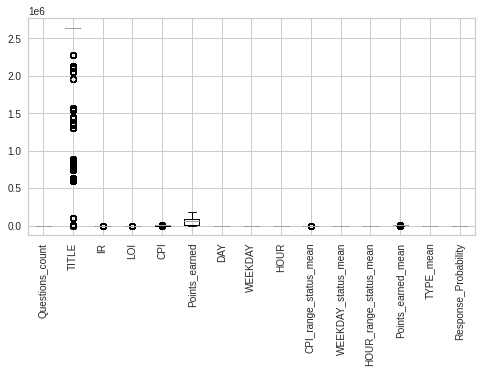

In [ ]:
# 이상치 제거 전 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

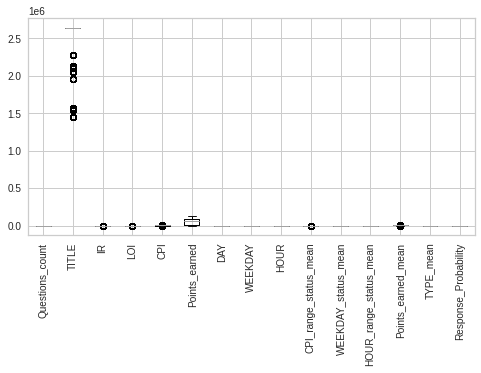

In [ ]:
# 수치형 변수 이상치 제거
features[num] = features[num].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 이상치 제거 후 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

In [ ]:
# DNN 모델링에서는 StandardScaler을 주로 사용
from sklearn.preprocessing import StandardScaler

# 스케일링 전 train, test 분할
X_train = features.iloc[:y_train.shape[0], :]
X_test = features.iloc[y_train.shape[0]:, :]

scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [ ]:
# 인코딩
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

# 피쳐 셀렉션

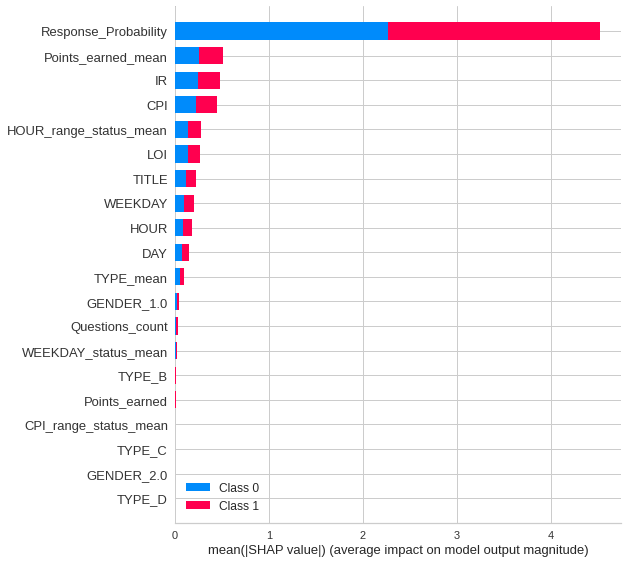

,column_name,shap_importance
14,Response_Probability,2.26392
12,Points_earned_mean,0.257854
2,IR,0.241027
4,CPI,0.223032
11,HOUR_range_status_mean,0.136582
3,LOI,0.133814
1,TITLE,0.114333
7,WEEKDAY,0.09885
8,HOUR,0.0893097
6,DAY,0.075633


In [ ]:
# Method: Using SHAP values (먼저 shap을 설치해야 함!!!)

import shap
from lightgbm import LGBMClassifier

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [ ]:
# feature 중요도가 0.03 이상
SHAP_THRESHOLD = 0.03  
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(1684770, 11)


In [ ]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(1684770, 17)


In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.4, random_state=77) # test size 올리기 

In [ ]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(1)
    tf.compat.v1.set_random_seed(1)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [ ]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


### dense 8 에폭 50 랜덤시드 1,2,3

In [ ]:
from keras.callbacks import ModelCheckpoint

input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(8, activation='relu')(input) # 은익층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=50, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_16 (Dense)            (None, 8)                 144       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
988/988 - 4s - loss: 0.4548 - acc: 0.7857 - auc_8: 0.8665 - val_loss: 0.4107 - val_acc: 0.8136 - val_auc_8: 0.8932 - 4s/epoch - 4ms/step
Epoch 2/50
988/988 - 3s - loss: 0.4056 - acc: 0.8159 - auc_8: 0.8957 - val_loss: 0.4035 - val_acc: 0.8170 - val_auc_8: 0.8968 - 3s/epoch - 3ms/step
Epoch 3/50
988/988 - 3s - los

### dense 32 에폭 50 시드 1,2,3

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(32, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=50, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                576       
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
988/988 - 4s - loss: 0.4271 - acc: 0.8041 - auc_3: 0.8840 - val_loss: 0.4022 - val_acc: 0.8184 - val_auc_3: 0.8975 - 4s/epoch - 4ms/step
Epoch 2/50
988/988 - 3s - loss: 0.3992 - acc: 0.8189 - auc_3: 0.8989 - val_loss: 0.3978 - val_acc: 0.8201 - val_auc_3: 0.8997 - 3s/epoch - 3ms/step
Epoch 3/50
988/988 - 3s - los

### dense 64 에폭 50 시드 1,2,3

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(64, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=50, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_8 (Dense)             (None, 64)                1152      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
988/988 - 5s - loss: 0.4152 - acc: 0.8103 - auc_4: 0.8902 - val_loss: 0.3979 - val_acc: 0.8198 - val_auc_4: 0.8996 - 5s/epoch - 5ms/step
Epoch 2/50
988/988 - 4s - loss: 0.3953 - acc: 0.8204 - auc_4: 0.9009 - val_loss: 0.3935 - val_acc: 0.8218 - val_auc_4: 0.9018 - 4s/epoch - 4ms/step
Epoch 3/50
988/988 - 4s -

### dense 64 에폭 50 시드 1,1,1

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(64, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=50, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 17)]              0         
                                                                 
 dense_18 (Dense)            (None, 64)                1152      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
988/988 - 4s - loss: 0.4215 - acc: 0.8058 - auc_9: 0.8865 - val_loss: 0.3985 - val_acc: 0.8199 - val_auc_9: 0.8993 - 4s/epoch - 4ms/step
Epoch 2/50
988/988 - 3s - loss: 0.3959 - acc: 0.8201 - auc_9: 0.9006 - val_loss: 0.3945 - val_acc: 0.8215 - val_auc_9: 0.9013 - 3s/epoch - 3ms/step
Epoch 3/50
988/988 - 3s -

### dense 128 에폭 50 시드 1,2,3

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(128, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=50, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_10 (Dense)            (None, 128)               2304      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
988/988 - 6s - loss: 0.4121 - acc: 0.8110 - auc_5: 0.8918 - val_loss: 0.3964 - val_acc: 0.8204 - val_auc_5: 0.9003 - 6s/epoch - 6ms/step
Epoch 2/50
988/988 - 5s - loss: 0.3937 - acc: 0.8211 - auc_5: 0.9017 - val_loss: 0.3918 - val_acc: 0.8225 - val_auc_5: 0.9028 - 5s/epoch - 5ms/step
Epoch 3/50
988/988 - 5s -

### dense 128 에폭 15 랜덤시드 1,2,3

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(128, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=15, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 17)]              0         
                                                                 
 dense_25 (Dense)            (None, 128)               2304      
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
988/988 - 5s - loss: 0.4105 - acc: 0.8128 - auc_12: 0.8928 - val_loss: 0.3963 - val_acc: 0.8207 - val_auc_12: 0.9004 - 5s/epoch - 5ms/step
Epoch 2/15
988/988 - 3s - loss: 0.3934 - acc: 0.8213 - auc_12: 0.9019 - val_loss: 0.3915 - val_acc: 0.8226 - val_auc_12: 0.9029 - 3s/epoch - 3ms/step
Epoch 3/15
988/988 -

### dense 128 에폭 15 랜덤시드 1,1,1

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(128, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=15, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 17)]              0         
                                                                 
 dense_27 (Dense)            (None, 128)               2304      
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
988/988 - 23s - loss: 0.4102 - acc: 0.8127 - auc_13: 0.8928 - val_loss: 0.3960 - val_acc: 0.8207 - val_auc_13: 0.9006 - 23s/epoch - 23ms/step
Epoch 2/15
988/988 - 19s - loss: 0.3935 - acc: 0.8211 - auc_13: 0.9018 - val_loss: 0.3918 - val_acc: 0.8226 - val_auc_13: 0.9027 - 19s/epoch - 19ms/step
Epoch 3/15
988

### dense 256, 에폭 8, 랜덤 시드 1,2,3

In [ ]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(256, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()
Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=8, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 17)]              0         
                                                                 
 dense_33 (Dense)            (None, 256)               4608      
                                                                 
 dense_34 (Dense)            (None, 1)                 257       
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
988/988 - 33s - loss: 0.4048 - acc: 0.8160 - auc_16: 0.8958 - val_loss: 0.3940 - val_acc: 0.8218 - val_auc_16: 0.9016 - 33s/epoch - 33ms/step
Epoch 2/8
988/988 - 29s - loss: 0.3908 - acc: 0.8225 - auc_16: 0.9032 - val_loss: 0.3887 - val_acc: 0.8240 - val_auc_16: 0.9044 - 29s/epoch - 29ms/step
Epoch 3/8
988/98

### dense 128 에폭 15 시드 1,2,3 그래프

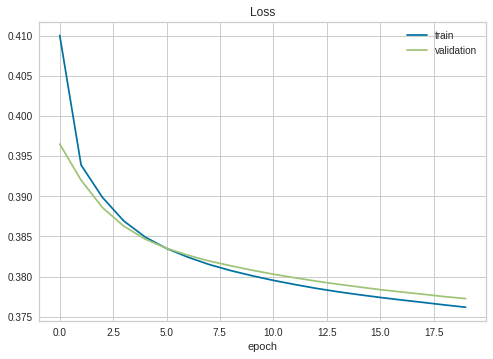

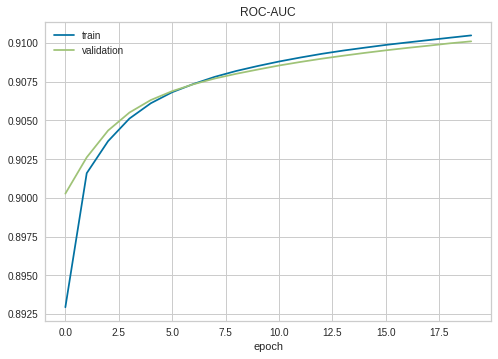

In [ ]:
# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

# ROC-AUC
plt.plot(hist.history["auc_10"], label="train")
plt.plot(hist.history["val_auc_10"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("ROC-AUC")
plt.show()

### dense 8 에폭 50 시드 1,2,3 그래프

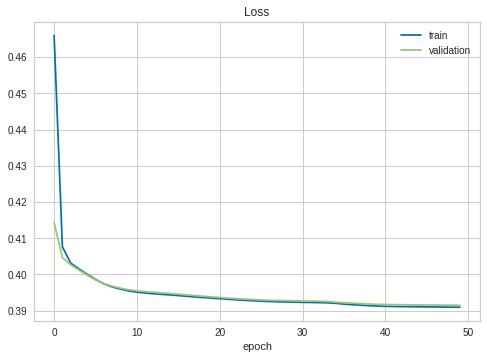

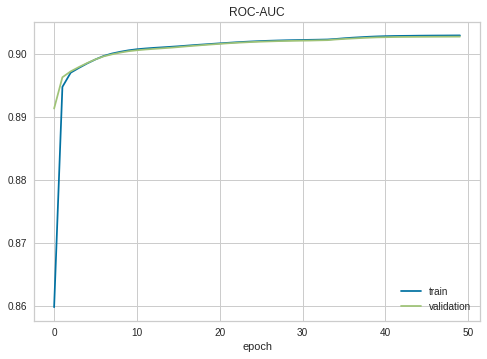

In [ ]:
# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

# ROC-AUC
plt.plot(hist.history["auc"], label="train")
plt.plot(hist.history["val_auc"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("ROC-AUC")
plt.show()

In [ ]:
pd.DataFrame({'ID': test_id["ID"], 'STATUS': DEEP.predict(X_test).flatten()}).to_csv(path + "deeplearning_0.9095.csv", index=False)

In [ ]:
joblib.dump(DEEP,path + "deeplearning_0.9095.pkl")

INFO:tensorflow:Assets written to: ram://07d2bbb6-ac3c-4d92-a7bc-ecce24e3ddd2/assets


['/content/drive/MyDrive/deeplearning_0.9095.pkl']

In [ ]:
pd.read_csv(path + 'deeplearning_0.9095.csv')

,ID,STATUS
0,0,0.956086
1,1,0.058894
2,2,0.605985
3,3,0.984701
4,4,0.042571
...,...,...
1355512,1355512,0.425824
1355513,1355513,0.017984
1355514,1355514,0.025669
1355515,1355515,0.161852


In [ ]:
print(os.getcwd())

/content


In [ ]:
print(os.path.abspath("deeplearning_0.9095.csv"))

/content/deeplearning_0.9095.csv


In [ ]:
os.path.abspath("../input")+'/panel.csv'

'/input/panel.csv'

In [ ]:
 pd.read_csv(os.path.abspath("/content/drive/MyDrive/input")+'/panel.csv')

,userID,BIRTH,GENDER,REGION,TYPE,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7
0,p00005,1979.0,2.0,2.0,D,2.0,1979.0,1,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p03884,1970.0,1.0,512.0,D,1.0,1970.0,8.0,1,3.0,2,4.0,3,"7,8",4,4,2,"1,5",6,"1,10,5,6,7,8",2,"1,9",1,1,"1,3",99,5,1.0,2,2,8,1,21,1,8.0,5.0,1.0
2,p02205,1957.0,2.0,2.0,D,2.0,1957.0,1.0,2,3.0,1,99.0,2,99,3,3,1,2,5,"2,3",3,"1,10,2,3,4,5,6,9",3,1,99,99,2,1.0,"4,",1,5,12,2,7,1.0,6.0,3.0
3,p12630,1997.0,1.0,512.0,B,1.0,1997.0,8.0,3,1.0,1,"1,10,13,18,2,3,4,5,6,7,8",3,3,9,2,3,1,99,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p14431,1992.0,2.0,512.0,C,2.0,1992.0,8.0,1,3.0,1,3.0,"1,13,2,21,3,4,5,6,9",3,3,5,9997,2,"10,2,3,5,6,8,9",4,2,"2,4,7,9",99,99,99,99,99,2.0,4,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16558,p01702,1988.0,1.0,512.0,D,1.0,1988.0,8,1,3.0,2,9.0,3,"17,18,3",8,1,1,"1,2,5",4,"1,10,12,2,3,6,9",2,"2,4,6",7,2,"1,2,3",3,20,1,2,3,4,1,19,2,8.0,9.0,1.0
16559,p05868,1993.0,1.0,512.0,B,1.0,1993.0,8,"1,",3,1,99,4,"1,10,12,13,15,16,18,2,3,4,5,7,8,9",8,4,1,"1,2,5,6","6,","11,9,1,3","5,","6,4","3,","2,",16,2,1,1,4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16560,p09312,1999.0,1.0,8.0,B,1.0,1999.0,7,1,1,3,"1,13,18,2,4,5,8,9",5,3,9,99,99,99,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16561,p09181,1997.0,1.0,64.0,D,1.0,1997.0,3,"1,",2,"1,",99,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(os.path.abspath("panel.csv"))

/content/panel.csv
